# [CDAF] Atividade 4

## Nome e matrícula
Nome: Diogo Tuler Chaves
Matrícula: 2022043663

## Referências
- [1] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- [2] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.ExpectedThreat.html#socceraction.xthreat.ExpectedThreat
- [3] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.get_successful_move_actions.html#socceraction.xthreat.get_successful_move_actions
- [4] https://socceraction.readthedocs.io/en/latest/documentation/valuing_actions/xT.html

In [1]:
# Importando bibliotecas
from tqdm import tqdm
import numpy as np
import pandas as pd
import socceraction.spadl as spd
from socceraction import xthreat as xt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from socceraction.xthreat import ExpectedThreat,get_successful_move_actions


### LaLiga  p/ SPADL com pré-processamentos

In [2]:
# carregando os eventos
path ="/home/diogo/Documents/Notebook_4/events_Spain.json"
events = pd.read_json(path_or_buf=path)

In [3]:
# pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                                'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
events['milliseconds'] = events['eventSec'] * 1000
events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

/tmp/ipykernel_13978/3735303047.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})


In [4]:
# carregando as partidas, pois vamos saber quais times jogam em casa e fora p/ usar como parametro do SPADL
path = "/home/diogo/Documents/Notebook_4/matches_Spain.json"
matches = pd.read_json(path_or_buf=path)

In [5]:
# as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
team_matches = []
for i in tqdm(range(len(matches))):
    match = pd.DataFrame(matches.loc[i, 'teamsData']).T
    match['matchId'] = matches.loc[i, 'wyId']
    team_matches.append(match)
team_matches = pd.concat(team_matches).reset_index(drop=True)

100%|██████████| 380/380 [00:00<00:00, 1391.14it/s]


In [6]:
# fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
spadl = []
game_ids = events.game_id.unique().tolist()
for g in tqdm(game_ids):
    match_events = events.loc[events.game_id == g]
    match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
    match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
    match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
    match_actions = spd.add_names(match_actions)
    spadl.append(match_actions)
spadl = pd.concat(spadl).reset_index(drop=True)

100%|██████████| 380/380 [03:22<00:00,  1.87it/s]


In [7]:
# adicionando o nome dos jogadores
path = "/home/diogo/Documents/Notebook_4/players.json"
players = pd.read_json(path_or_buf=path)
players['player_name'] = players['firstName'] + ' ' + players['lastName']
players = players[['wyId', 'player_name']].rename(columns={'wyId': 'player_id'})
spadl = spadl.merge(players, on='player_id', how='left')

## Questão 1
- Crie um dataframe "shots" à partir do dataframe "spadl", contendo apenas os chutes.
- Crie 4 colunas no dataframe "shots" a serem usadas como features de um modelo de xG.
- Justifique a escolha das features.

In [8]:
spadl_shots = spadl.query("type_name == 'shot'")
spadl_shots_filtered = spadl_shots[["bodypart_id","start_x","start_y","team_id"]]

Justificativa para escolhas:
* __bodypart_id__ = A parte do corpo usada no chute influencia o resultado dele.

* __start_x__ = Onde o chute começou é um dos fatores mais importantes para determinar o resultado dele.

* __start_y__ = Onde o chute começou é um dos fatores mais importantes para determinar o resultado dele.

* __team_id__ = Times possuem diferentes táticas de chutes e características de jogadores, logo o time que está chutando influencia o resultado do chute.

## Questão 2
- Crie uma coluna numérica binária "goal" no dataframe "shots" indicando se o chute resultou em gol ou não.
- Use regressão logística [1] p/ treinar (.fit(X_train, y_train)) um modelo de xG usando as features criadas na questão 1.
- Use 70% dos dados para treino e 30% para teste.
- Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

In [9]:
labels = spadl_shots["result_id"].to_numpy()
features = spadl_shots_filtered.to_numpy()

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=0)


In [11]:
model = LogisticRegression(random_state=0)
model.fit(features_train, labels_train)

LogisticRegression(random_state=0)

In [12]:
def metric(y_true, y_pred):
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred , average= 'macro')
        recall = metrics.recall_score(y_true, y_pred, average= 'macro')
        f1 = metrics.f1_score(y_true, y_pred,average= 'macro')
        report_table = {
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1 Score': [f1]
        }

        report_table_df = pd.DataFrame(report_table)

        fig, ax = plt.subplots(figsize=(20, 1))
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(cellText=report_table_df.values, colLabels=report_table_df.columns, cellLoc='center', loc='center')
        table.scale(1,2)

        for key, cell in table.get_celld().items():
            if key[0] == 0:
                cell.set_text_props(weight='bold')
                
        plt.show()

/home/diogo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


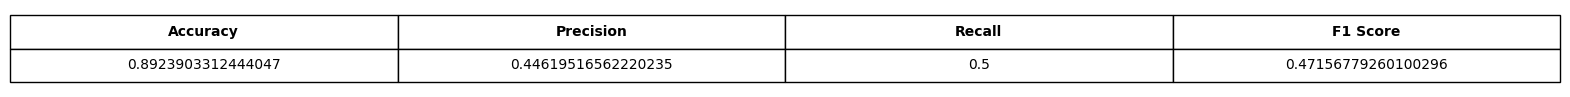

In [13]:
predicted_train = model.predict(features_train)
metric(labels_train, predicted_train)

/home/diogo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


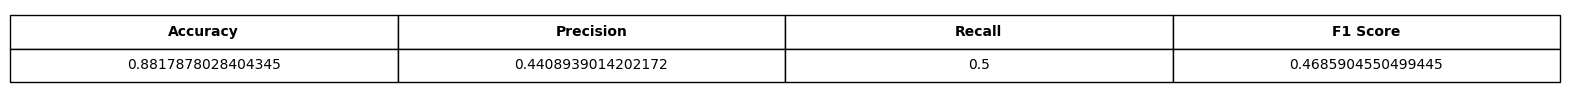

In [14]:
predicted_test = model.predict(features_test)
metric(labels_test, predicted_test)

## Questão 3
- Use o modelo treinado na questão 2 p/ prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".
- Agrupe o dataframe "shots" por "player_name" e reporte a soma dos "goal" e "xG".
- Reporte os 10 jogadores com maior xG.
- Reporte os 10 jogadores com maior diferença de Gols e xG.

In [15]:
predicted_shots = model.predict_proba(features)
spadl_shots.loc[:, "xG"] = predicted_shots[:, 1]
spadl_shots

/tmp/ipykernel_13978/666890888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spadl_shots.loc[:, "xG"] = predicted_shots[:, 1]


,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,xG
20,2565548,1,57.771186,695,225089,97.65,44.88,105.00,34.00,180865315,4,11,0,20,shot,fail,foot_left,Jos\u00e9 Luis Morales Nogales,0.189839
22,2565548,1,60.727239,695,255738,84.00,27.88,84.00,27.88,180864547,5,11,0,22,shot,fail,foot_right,Jefferson Andr\u00e9s Lerma Sol\u00eds,0.041336
93,2565548,1,446.986112,682,37831,92.40,29.24,92.40,29.24,180864486,5,11,0,93,shot,fail,foot_right,Carlos Arturo Bacca Ahumada,0.126369
96,2565548,1,488.929113,682,15214,91.35,23.12,105.00,27.20,180864491,5,11,0,96,shot,fail,foot_right,Antonio Rukavina,0.110837
180,2565548,1,948.872079,695,225089,78.75,40.80,105.00,34.00,180864792,5,11,0,180,shot,fail,foot_right,Jos\u00e9 Luis Morales Nogales,0.020540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474463,2565927,2,1776.027412,682,267134,97.65,23.12,97.65,23.12,253302272,5,11,0,1225,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,0.229873
474502,2565927,2,1944.188119,682,267134,94.50,46.24,94.50,46.24,253302329,5,11,0,1264,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,0.163366
474634,2565927,2,2385.837008,682,134174,96.60,51.00,105.00,37.40,253302547,4,11,1,1396,shot,success,foot_left,Samuel Castillejo Azuaga,0.175381
474679,2565927,2,2722.835144,675,3321,86.10,47.60,105.00,30.60,253302642,5,11,0,1441,shot,fail,foot_right,Karim Benzema,0.058829


In [16]:
players_XG = spadl_shots[["xG", "player_name", "result_id"]].reset_index()[["xG", "player_name", "result_id"]]

In [17]:
players_XG = players_XG.groupby("player_name").sum()

In [18]:
players_XG_top_10 = players_XG.sort_values(by='xG',ascending=False)[:10]
print("JOGADORES COM MAIOR XG")
players_XG_top_10

JOGADORES COM MAIOR XG


,xG,result_id
player_name,,
Cristiano Ronaldo dos Santos Aveiro,22.457181,23
Luis Alberto Su\u00e1rez D\u00edaz,19.618973,24
Lionel Andr\u00e9s Messi Cuccittini,16.583570,26
Gerard Moreno Balaguero,13.237445,15
I\u00f1aki Williams Arthuer,11.742526,7
Maximiliano G\u00f3mez Gonz\u00e1lez,11.487468,18
Iago Aspas Juncal,10.659807,19
Enrique Garc\u00eda Mart\u00ednez,10.215677,8
Carlos Arturo Bacca Ahumada,9.978681,14


In [19]:
players_XG.loc[:, "Difference"] = players_XG["result_id"].to_numpy() - players_XG["xG"].to_numpy()
players_XG_top_10_difference = players_XG.sort_values(by='Difference',ascending=False)[:10]

print("JOGADORES COM MAIOR DIFERENÇA POSITIVA DE GOLS E xG")
players_XG_top_10_difference

JOGADORES COM MAIOR DIFERENÇA POSITIVA DE GOLS E xG


,xG,result_id,Difference
player_name,,,
Lionel Andr\u00e9s Messi Cuccittini,16.583570,26,9.416430
Antoine Griezmann,6.932646,16,9.067354
Cristhian Ricardo Stuani Curbelo,7.483867,16,8.516133
Iago Aspas Juncal,10.659807,19,8.340193
Gareth Frank Bale,8.304043,15,6.695957
Maximiliano G\u00f3mez Gonz\u00e1lez,11.487468,18,6.512532
Mikel Oyarzabal Ugarte,5.931145,12,6.068855
Rodrigo Moreno Machado,9.515743,15,5.484257
\u00c1ngel Luis Rodr\u00edguez D\u00edaz,8.093054,13,4.906946


In [20]:
players_XG_top_10_difference = players_XG.sort_values(by='Difference',ascending=False)[-10:]

print("JOGADORES COM MAIOR DIFERENÇA NEGATIVA GOLS E xG")
players_XG_top_10_difference

JOGADORES COM MAIOR DIFERENÇA NEGATIVA GOLS E xG


,xG,result_id,Difference
player_name,,,
Ra\u00fal Garc\u00eda Escudero,9.308719,7,-2.308719
Adnan Januzaj,5.453680,3,-2.453680
Guilherme dos Santos Torres,2.513033,0,-2.513033
Carlos Soler Barrag\u00e1n,3.547388,1,-2.547388
Franco Dami\u00e1n V\u00e1zquez,6.715197,4,-2.715197
Sandro Ram\u00edrez Castillo,2.969295,0,-2.969295
Jorge Molina Vidal,7.836876,4,-3.836876
I\u00f1aki Williams Arthuer,11.742526,7,-4.742526
Jonathan Calleri,9.166842,4,-5.166842


## Questão 4
- Instancie um objeto ExpectedThreat [2] com parâmetros l=25 e w=16.
- Faça o fit do modelo ExpectedThreat com o dataframe "spadl".

In [21]:
xthreat = ExpectedThreat(l=25, w=16)
xthreat.fit(spadl)

# iterations:  29


## Questão 5
- Crie um dataframe "prog_actions" à partir do dataframe "spadl", contendo apenas as ações de progressão e que são bem-sucedidas [3].
- Use o método rate do objeto ExpectedThreat p/ calcular o valor de cada ação de progressão do dataframe "prog_actions", em uma coluna chamada "action_value".
- Agrupe o dataframe "prog_actions" por "player_name" e reporte a soma dos "action_value".
- Reporte os 10 jogadores com maior "action_value".

In [34]:
prog_actions = get_successful_move_actions(spadl)
prog_actions['action_value'] = xthreat.rate(prog_actions)
prog_actions = prog_actions[["player_name","action_value"]]
prog_actions = prog_actions.groupby("player_name").sum().sort_values(by='action_value',ascending=False)[:10]

In [36]:
print("JOGADORES COM MAIOR ACTION_VALUE")
prog_actions

JOGADORES COM MAIOR ACTION_VALUE


,action_value
player_name,
Marcelo Vieira da Silva J\u00fanior,11.500223
Lionel Andr\u00e9s Messi Cuccittini,10.782755
\u00c1lvaro Odriozola Arzallus,8.911590
Juan Francisco Moreno Fuertes,7.906469
Hugo Mallo Novegil,7.895647
Jos\u00e9 Luis Morales Nogales,7.886556
Roberto Jos\u00e9 Rosales Altuve,7.150794
Jordi Alba Ramos,7.139224
\u00c9ver Maximiliano David Banega,7.128678
